# Chapter 2: Simulating Stochastic Rainfall Processes

In this chapter, we will use some of the principles and code introduced in Chapter 1 to develop a very simple model of daily rainfall. We will be able to use this model to simulate many seasons of daily rainfall that we can analyze. In addition, we will use actual rainfall data collected in Laikipia, Kenya to estimate the parameters of our model. This will allow us to simulate how rainfall variability and farmer decision making interact to affect food security outcomes in the next chapter.

## Chapter Objectives

* Develop a simple model of growing season daily rainfall
* Use the model to examine variability in growing season rainfall
* Extract model parameters from long-term rainfall data collected in Laikipia, Kenya
* Use the model to generate realizations of rainfall under altered climates
* Examine the impact of changing model parameters on rainfall variability 

In [111]:
import pandas as pd
import numpy as np

# Part 1. Modeling rainfall

Let's make a very simple model of rainfall that assumes a poisson process (i.e. memoryless). In the last chapter, we saw that this approach is probably too simple, and later we will look at how we could improve the model. But it helps to start with the most simple approach and then add complexity as needed.

Our model will be built with the following assumptions:

1. The probability of an "event" (i.e. rainfall) occuring on any given day is given by the parameter $\lambda_r$, which has units day$^{-1}$

2. The total depth of rainfall on days with rain is a random variable, drawn from an exponential distribution with mean, $\alpha$, which has units of mm.

This type of model is a ["marked poisson process"](http://www.math.kit.edu/stoch/~last/seite/lectures_on_the_poisson_process/media/lastpenrose2017.pdf) and is a special case of a poisson process on a number line (in our case, the number line is time), where each event is characterized by a random "mark" that is independent of the event.

### Step 1. Simulating poisson events

We have a variety of means to simulate a poisson process, and all of them will require the use of a random number generator. The `numpy` package has lots of different builtin functions to generate pseudo-random numbers, and we can use one of these. 

To simulate the likelihood of a poisson event, we can draw a sample from a uniform distribution in $[0,1]$ and compare that to our probability of an event. If the value we draw is less than or equal to our probability, then an event occurs, otherwise no event occurs. The probability density function, $f(x)$ of a uniform distribution sampled over the half open interval from $a$ to $b$, $[a,b)$ is given by 

$$
f(x) = \frac{1}{b - a}
$$


We can sample from this distribution using the [**numpy.random.uniform()**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html) function:

```python

s = np.random.uniform(low=0,high=1)

```

The **np.random.uniform()** function also takes the optional argument `size`, which specifies the number of random samples to return. This allows for the generation of large lists of random samples without using a `for` loop or list comprehension approaches.

```python

s = np.random.uniform(low=0, high=1, size=2) # Returns an array of 2 random draws.

s_mat = np.random.uniform(low=0, high=1, size=[2, 10]) # Returns an array of 2 rows each with 10 random draws.


```

<div class="alert alert-success">✏️ **DIY Coding**: Using a $\lambda_r$ value of `0.15`, and assuming that the length of a growing season, $T_{seas}$, is 120 days, simulate a season of rainfall "events", where the value of a day is `1` if rainfall occurs, and `0` if not.</div>

<div class="alert alert-info">💡 You can use the **astype()** command to force Boolean (`True`/`False`) values into integers (`1`,`0`)</div>

In [112]:
# This cell intentionally left blank.

### Step 2. Adding marks to events

Our approach for creating marks (i.e. daily rainfall depths) is to sample them randomly from an exponential distribution with mean $\alpha$. The exponential probability density function $f(x)$ for $x\gt0$ as a function of $\alpha$ is expressed as 

$$
f(x) = \frac{1}{\alpha} \exp\left(-\frac{x}{\alpha}\right),
$$

Just as with sampling from a uniform distribution (and as with most everything in `python/pandas`), there's a **function** for that. In this case, we are going to use the... you guessed it... [**np.random.exponential()**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.exponential.html) function. It is used similarly to the **np.random.uniform()** function, but with a single parameter to describe the distribution:

```python

s = np.random.exponential(scale=11.5)  

```

The `scale` parameter is the mean of the distribution, which in our simulations will be $\alpha$ (mm), the average rainfall depth on days with rain. Just as with **np.random.uniform()**, we can generate lists or arrays of samples from the exponential distribution.

```python

s = np.random.exponential(scale=11.5, size=2) # Returns an array of 2 random draws.

s_mat = np.random.uniform(scale=11.5, size=[2, 10]) # Returns an array of 2 rows each with 10 random draws.

```
<div class="alert alert-success">✏️ **DIY Coding**: Assuming an average storm depth of `11.5 (mm)` and the samne $\alpha$ and $T_{seas}$ as before, generate a season of rainfall.</div>

<div class="alert alert-info">💡 The product of `0` and any rainfall amount is still `0`. That means you don't need to worry about which days have rain and which don't when multiplying a list of `rainfall_amounts` and a binary list of `rain_days`.</div>

CV is 0.31226152443994415


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12197bc50>]],
      dtype=object)

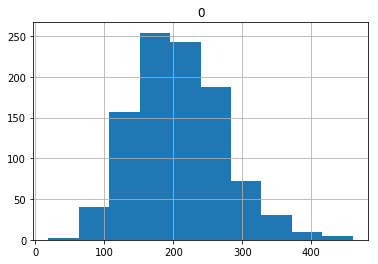

In [113]:
# This cell intentionally left blank

<div class="alert alert-success">✏️ **DIY Coding**: Using the same $\lambda_r$, $\alpha$, and $T_{seas}$, do the following:</div>

1. Generate 100 seasons of rainfall
2. Plot a histogram of the seasonal totals
3. Calculate the $\widehat{CV}$ of seasonal rainfall.



In [114]:
# This cell intentionally left blank

# Part 2. Estimate model parameters

We actually introduced most of the code necessary to determine model parameters from our rainfall data in the previous chapter. In order to have a little more fun, we're bringing in a much larger dataset of stations from around Laikipia county, Kenya. These stations span a fairly large range of annual rainfall and therefore provide a nice testbed for thinking about climate variability and agriculture. As we develop our analyses, we'll write code in a way that makes it easy to switch between stations and see how our results vary across the region.

## Reading in the rainfall dataset.

After reading in the data, where going to use some built-in `pandas` and `python` functions for manipulating `DateTime` objects. These functions will:

1. **Convert text strings** contained in the `RDate` column into `DateTime` objects. We will do this using a `format` string that defines the structure of the dates as they are represented in `RDate`. The function that we will use to do the conversion is the `pandas` builtin function called **to_datetime()**.

2. **Reassign date values** for dates from the first half of the 20th century, that **to_datetime()** mistakenly thinks are for the first half of the _21st_ century. This happens because our data represented years with two digits instead of four. **Note:** This is the ["Y2K problem"](https://en.wikipedia.org/wiki/Year_2000_problem) that many of you probably haven't heard of but briefly had people worrying that planes would fall from the skies on Jan 1, 2000.

<div class="alert alert-warning">🗓️ **Bottom Line:** Dealing with dates and times is always difficult! Always check to make sure things look correct after any conversion. And don't be afraid to ask/look for help!</div>

3. Extract new columns from our corrected `DateTime` objects that represent the `Year` and `Month` and save them into the `DataFrame`.

4. Assign our corrected `DateTime` values as the `index` of the dataframe, which means that instead of storing data by "row number", data will be stored according to unique date values. 

<div class="alert alert-warning">🗂️ When specifying an `index` column in `pandas`, it's necessary that the index is unqiue for each row of data. If we had multiple rows with the same date, this would not work.</div>

5. Delete the original `RDate` column, which we no longer need. This isn't strictly necessary, but it's just good hygenie to clean up `DataFrames` as much as possible. And we can always re-import the original `.csv` file if we needed to get at `RDate` again.

<div class="alert alert-info">💡 When doing complicated, multi-step transformations, it's good practice to itemize each step in a `markdown` cell before the `code` cell, and to match your code comments to the itemized list.</div>


In [115]:
from datetime import datetime
from dateutil.relativedelta import *

df = pd.read_csv("../data/CETRAD_rainfall.csv")  # Read in the raw csv data.

# Step 1. Convert text strings into datetime objects.
format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
df['Year'] = [dt.year for dt in df['Datetime']]
df['Month'] = [dt.month for dt in df['Datetime']]

# Step 4. Use the Datetime values as the index for this dataframe.
df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# Step 5.  Delete the old RDate column, which we no longer need. 
# We will keep the Datetime column, in case we need it later.
df = df.drop(['RDate'], axis=1)

Let's make sure all of these transformations worked.

In [116]:
df.head()

,ARCHERS POST,ARDENCAPLE FARM,CASTLE FOREST STN,CHOGORIA FOREST STN,CHUKA FOREST STN,COLCHECCIO,DOL DOL DAO,EL KARAMA,EMBORI FARM,EMBU MET STN,...,SOUTH MARMANET FOREST STN,SUGUROI ESTATE,TELEKI (MT KENYA),TELESWANI (NRM),THARUA FARM,TIMAU MARANIA,TRENCH FARM,Datetime,Year,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
1934-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-01,1934,1
1934-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-02,1934,1
1934-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-03,1934,1
1934-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-04,1934,1
1934-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-05,1934,1


Looks okay. There are a ton of `NaN` values because only one or two stations have data in the 1930s. Let's look at the most recent data.

In [117]:
df.tail()

,ARCHERS POST,ARDENCAPLE FARM,CASTLE FOREST STN,CHOGORIA FOREST STN,CHUKA FOREST STN,COLCHECCIO,DOL DOL DAO,EL KARAMA,EMBORI FARM,EMBU MET STN,...,SOUTH MARMANET FOREST STN,SUGUROI ESTATE,TELEKI (MT KENYA),TELESWANI (NRM),THARUA FARM,TIMAU MARANIA,TRENCH FARM,Datetime,Year,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-27,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-27,2016,11
2016-11-28,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-28,2016,11
2016-11-29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-29,2016,11
2016-11-30,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-30,2016,11
2016-12-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01,2016,12


Again, we see that only a few stations have the most recent data. This is probably because they hadn't been coalated yet. In many places of Sub-Saharan Africa, it can take up to 5 years for rainfall data to get reported. 

Each column is a set of rainfall data for a specific location.

In [118]:
station_list = [station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']]
print(station_list)

['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO', 'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN', 'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)', 'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM', 'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN', 'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM', 'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS', 'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST', 'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN', 'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM', 'NYERI MOW', 'OL ARABEL FOREST STN

<div class="alert alert-warning">📍We won't do any mapping in this module. But, just in case, the geographhic locations for most of these stations are provided in the `../data/precipitation_gauge_locations.csv`. The coordinates in that file are in `UTM, Zone 37 North` projection, using the `Arc1960` projection.</div>

<div class="alert alert-success">✏️ **DIY Coding**: Determine the mean annual rainfall for each station</div>

<div class="alert alert-info">💡 Go back to Chapter 1 if necessary, and take a look at our good friend `groupby`. Also, don't forget about using `min_count` when doing sums to missing or under-reported years from your analyses.</div>

In [119]:
yearly = df.groupby(['Year'])[station_list].sum(min_count=350).mean()
print(yearly)

ARCHERS POST                  354.623529
ARDENCAPLE FARM               635.472571
CASTLE FOREST STN            2169.496757
CHOGORIA FOREST STN          2297.103846
CHUKA FOREST STN             1915.845556
COLCHECCIO                    453.218198
DOL DOL DAO                   541.596429
EL KARAMA                     718.225883
EMBORI FARM                   687.752435
EMBU MET STN                 1247.538171
ENASOIT FARM                  574.016129
GATHIURU FOREST STN           977.906115
HOMBE FOREST STN              981.524486
IRANGI FOREST STN            1964.711111
ISIOLO DAO                    678.560417
JACOBSON FARM                 744.008562
JUNCTION (EWASO NAROK)        464.822222
KABARU FOREST STN            1000.107143
KAGURU                       1794.706667
KALALU (NRM)                  778.425000
KAMWAKI FARM                  631.860903
KARURI (NRM)                  871.718182
KINAMBA MOW                   828.436364
KISIMA FARM                   851.346587
LAMURIA MET STN 